In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/mammo-224-224-ver2/split_data.csv")
df = df[df["split"] == "training"]
df["breast_birads"].value_counts()

breast_birads
BI-RADS 1    8609
BI-RADS 2    2956
BI-RADS 3     594
BI-RADS 4     493
BI-RADS 5     148
Name: count, dtype: int64

In [2]:
sampled_df = df.groupby('breast_birads', group_keys=False).apply(lambda x: x.sample(min(len(x), 150))).reset_index(drop=True)
print(sampled_df["breast_birads"].value_counts())

breast_birads
BI-RADS 1    150
BI-RADS 2    150
BI-RADS 3    150
BI-RADS 4    150
BI-RADS 5    148
Name: count, dtype: int64


/tmp/ipykernel_33/893371081.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('breast_birads', group_keys=False).apply(lambda x: x.sample(min(len(x), 150))).reset_index(drop=True)


In [3]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os
import torch

mean = [0.2652, 0.2652, 0.2652]
std = [0.1994, 0.1994, 0.1994]

class Mydataset(Dataset):
    def __init__(self, df, root):
        super(Mydataset, self).__init__()
        self.root = root
        image_paths_df = df["study_id"] + "/" + df["image_id"] +".png"
        self.image_paths = image_paths_df.tolist()
        label_df = df["breast_birads"]
        self.labels = label_df.tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_paths[idx])
        img = self._read_image(img_path, (224,224))
        label = int(self.labels[idx][-1])
        return img, torch.tensor(label).to(torch.long)
    
    def _read_image(self, filepath, new_size):
        image_pil = Image.open(filepath)
        
        # Kiểm tra chế độ của ảnh
        if image_pil.mode != 'L':
            image_pil = image_pil.convert('L')  # Chuyển đổi sang chế độ 'L' (grayscale) nếu cần thiết
        
        # Tạo ảnh RGB từ ảnh đơn kênh bằng cách sao chép giá trị của kênh đó vào cả ba kênh
        image_pil = Image.merge('RGB', (image_pil, image_pil, image_pil))
        
        # Resize ảnh
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        resized_image = transform(image_pil)
        resized_image = resized_image.to(torch.float)
        
        return resized_image
        

In [4]:
# --------------------------------------------------------
# SimMIM
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Based on BEIT code bases (https://github.com/microsoft/unilm/tree/master/beit)
# Written by Yutong Lin, Zhenda Xie
# --------------------------------------------------------

import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # comment out this for the orignal BERT implement
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., window_size=None, attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        if window_size:
            self.window_size = window_size
            # cls to token & token to cls & cls to cls
            self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH

            # get pair-wise relative position index for each token inside the window
            coords_h = torch.arange(window_size[0])
            coords_w = torch.arange(window_size[1])
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
            relative_coords[:, :, 1] += window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * window_size[1] - 1
            relative_position_index = \
                torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
            relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            relative_position_index[0, 0:] = self.num_relative_distance - 3
            relative_position_index[0:, 0] = self.num_relative_distance - 2
            relative_position_index[0, 0] = self.num_relative_distance - 1

            self.register_buffer("relative_position_index", relative_position_index)
        else:
            self.window_size = None
            self.relative_position_bias_table = None
            self.relative_position_index = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, rel_pos_bias=None):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        if self.relative_position_bias_table is not None:
            relative_position_bias = \
                self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                    self.window_size[0] * self.window_size[1] + 1,
                    self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)

        if rel_pos_bias is not None:
            attn = attn + rel_pos_bias

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, window_size=window_size, attn_head_dim=attn_head_dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, rel_pos_bias=None):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class RelativePositionBias(nn.Module):

    def __init__(self, window_size, num_heads):
        super().__init__()
        self.window_size = window_size
        self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        # cls to token & token 2 cls & cls to cls

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = \
            torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
        relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        relative_position_index[0, 0:] = self.num_relative_distance - 3
        relative_position_index[0:, 0] = self.num_relative_distance - 2
        relative_position_index[0, 0] = self.num_relative_distance - 1

        self.register_buffer("relative_position_index", relative_position_index)

    def forward(self):
        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1] + 1,
                self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
        return relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None,
                 use_abs_pos_emb=True, use_rel_pos_bias=False, use_shared_rel_pos_bias=False,
                 use_mean_pooling=True, init_scale=0.001):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.in_chans = in_chans

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if use_abs_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        else:
            self.pos_embed = None
        self.pos_drop = nn.Dropout(p=drop_rate)

        if use_shared_rel_pos_bias:
            self.rel_pos_bias = RelativePositionBias(window_size=self.patch_embed.patch_shape, num_heads=num_heads)
        else:
            self.rel_pos_bias = None

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.use_rel_pos_bias = use_rel_pos_bias
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values, window_size=self.patch_embed.patch_shape if use_rel_pos_bias else None)
            for i in range(depth)])
        self.norm = nn.Identity() if use_mean_pooling else norm_layer(embed_dim)
        self.fc_norm = norm_layer(embed_dim) if use_mean_pooling else None

        if self.pos_embed is not None:
            self._trunc_normal_(self.pos_embed, std=.02)
        self._trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)
        self.fix_init_weight()

    def _trunc_normal_(self, tensor, mean=0., std=1.):
        trunc_normal_(tensor, mean=mean, std=std)

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            self._trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            self._trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        for blk in self.blocks:
            x = blk(x, rel_pos_bias=rel_pos_bias)

        x = self.norm(x)
        if self.fc_norm is not None:
            t = x[:, 1:, :]
            return self.fc_norm(t.mean(1))
        else:
            return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        return x


def build_vit(config):
    model = VisionTransformer(
        img_size=config.DATA.IMG_SIZE,
        patch_size=config.MODEL.VIT.PATCH_SIZE,
        in_chans=config.MODEL.VIT.IN_CHANS,
        embed_dim=config.MODEL.VIT.EMBED_DIM,
        depth=config.MODEL.VIT.DEPTH,
        num_heads=config.MODEL.VIT.NUM_HEADS,
        mlp_ratio=config.MODEL.VIT.MLP_RATIO,
        qkv_bias=config.MODEL.VIT.QKV_BIAS,
        drop_rate=config.MODEL.DROP_RATE,
        drop_path_rate=config.MODEL.DROP_PATH_RATE,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        init_values=config.MODEL.VIT.INIT_VALUES,
        use_abs_pos_emb=config.MODEL.VIT.USE_APE,
        use_rel_pos_bias=config.MODEL.VIT.USE_RPB,
        use_shared_rel_pos_bias=config.MODEL.VIT.USE_SHARED_RPB,
        use_mean_pooling=config.MODEL.VIT.USE_MEAN_POOLING)

    return model



In [27]:
import torch
import torch.nn as nn

class ViTEncoder(nn.Module):

    def __init__(self, base_model, config, out_dim):
        super(ViTEncoder, self).__init__()
        self.model_dict = {"vit": build_vit(config),
                            "swin": None}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.embed_dim

        # add mlp projection head
#         self.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp),
#                                 nn.ReLU(),
#                                 torch.nn.Dropout(0.1),
#                                 nn.Linear(dim_mlp, 512),
#                                 nn.ReLU(),
#                                 torch.nn.Dropout(0.1),
#                                 nn.Linear(512, out_dim)
#                                 )

    def _get_basemodel(self, model_name):
        try:
            model = self.model_dict[model_name]
        except Exception:
            print("Invalid backbone architecture. Check the config file and pass one of: Vit or Swin Transformer")
        else:
            return model

    def forward(self, x):
        out = self.backbone(x)
        return out


In [30]:
import yaml

class AttrDict(dict):
    """A dictionary that allows for attribute-style access."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        for key, value in self.items():
            if isinstance(value, dict):
                value = AttrDict(value)
            self[key] = value

    def __getattr__(self, item):
        try:
            return self[item]
        except KeyError:
            raise AttributeError(f"'AttrDict' object has no attribute '{item}'")
with open("/kaggle/input/vit-config/simmim_pretrain__vit_base__img224__800ep.yaml", 'r') as file:
    data = yaml.safe_load(file)
model_config = AttrDict(data)
model = ViTEncoder("vit", model_config, 256)
print(len(model.state_dict().keys()))

187


In [34]:
checkpoint = torch.load("/kaggle/input/simmim/weights_setting2/resnet50BasedModel_2024-06-09 08:25:05.259872/best.pt", map_location = "cpu")["model_state_dict"]
count = 0
new_checkpoint = {}
for key, value in checkpoint.items():
    key_item = "backbone."+key[8:]
    if key_item in model.state_dict():
        new_checkpoint[key_item] = value
torch.save(new_checkpoint, "/kaggle/working/SiMIM-ViT-Encoder.pt")
model.load_state_dict(new_checkpoint)

<All keys matched successfully>

In [36]:
from torch.utils.data import DataLoader
import os
import yaml
            
dataset = Mydataset(sampled_df, "/kaggle/input/mammo-224-224-ver2/Processed_Images")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count())

In [41]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Lấy embeddings từ mô hình
test_targets = []
test_embeddings = torch.zeros((0, 768))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.eval()
model = model.to(device)
with torch.no_grad():
    for data in tqdm(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        output = model(inputs)
        test_targets.append(labels)
        test_embeddings = torch.cat((test_embeddings, output.detach().cpu().flatten().unsqueeze(0)), axis=0)
# Chuyển đổi danh sách thành tensor
test_embeddings = np.array(test_embeddings)
test_targets = np.array(torch.stack(test_targets).flatten())


cpu


100%|██████████| 748/748 [04:20<00:00,  2.87it/s]


/tmp/ipykernel_33/2088610494.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


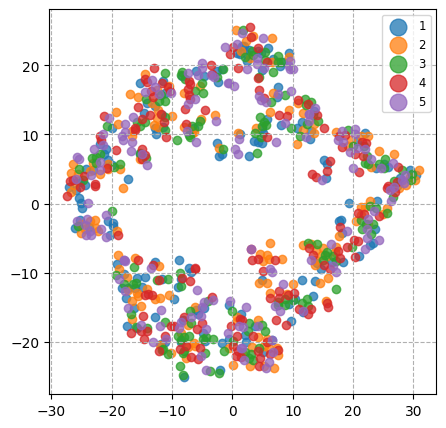

In [48]:
from matplotlib import cm
from sklearn.manifold import TSNE
import numpy as np

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]


tsne = TSNE(n_components=2, init='pca', perplexity=30, metric="cosine", early_exaggeration=12, n_iter=1000, random_state=1)
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(5,5))
num_categories = 5
for lab in range(1, num_categories+1):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.75)
ax.legend(fontsize='small', markerscale=2)
plt.grid(linestyle='--')
plt.savefig('/kaggle/working/ViT-SimMIM.png')
plt.show()


/tmp/ipykernel_33/1213117697.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_33/1213117697.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], label=f'Class {lab}', alpha=0.75, cmap=cmap)
/tmp/ipykernel_33/1213117697.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_33/1213117697.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], alpha=0.75, cmap=cm

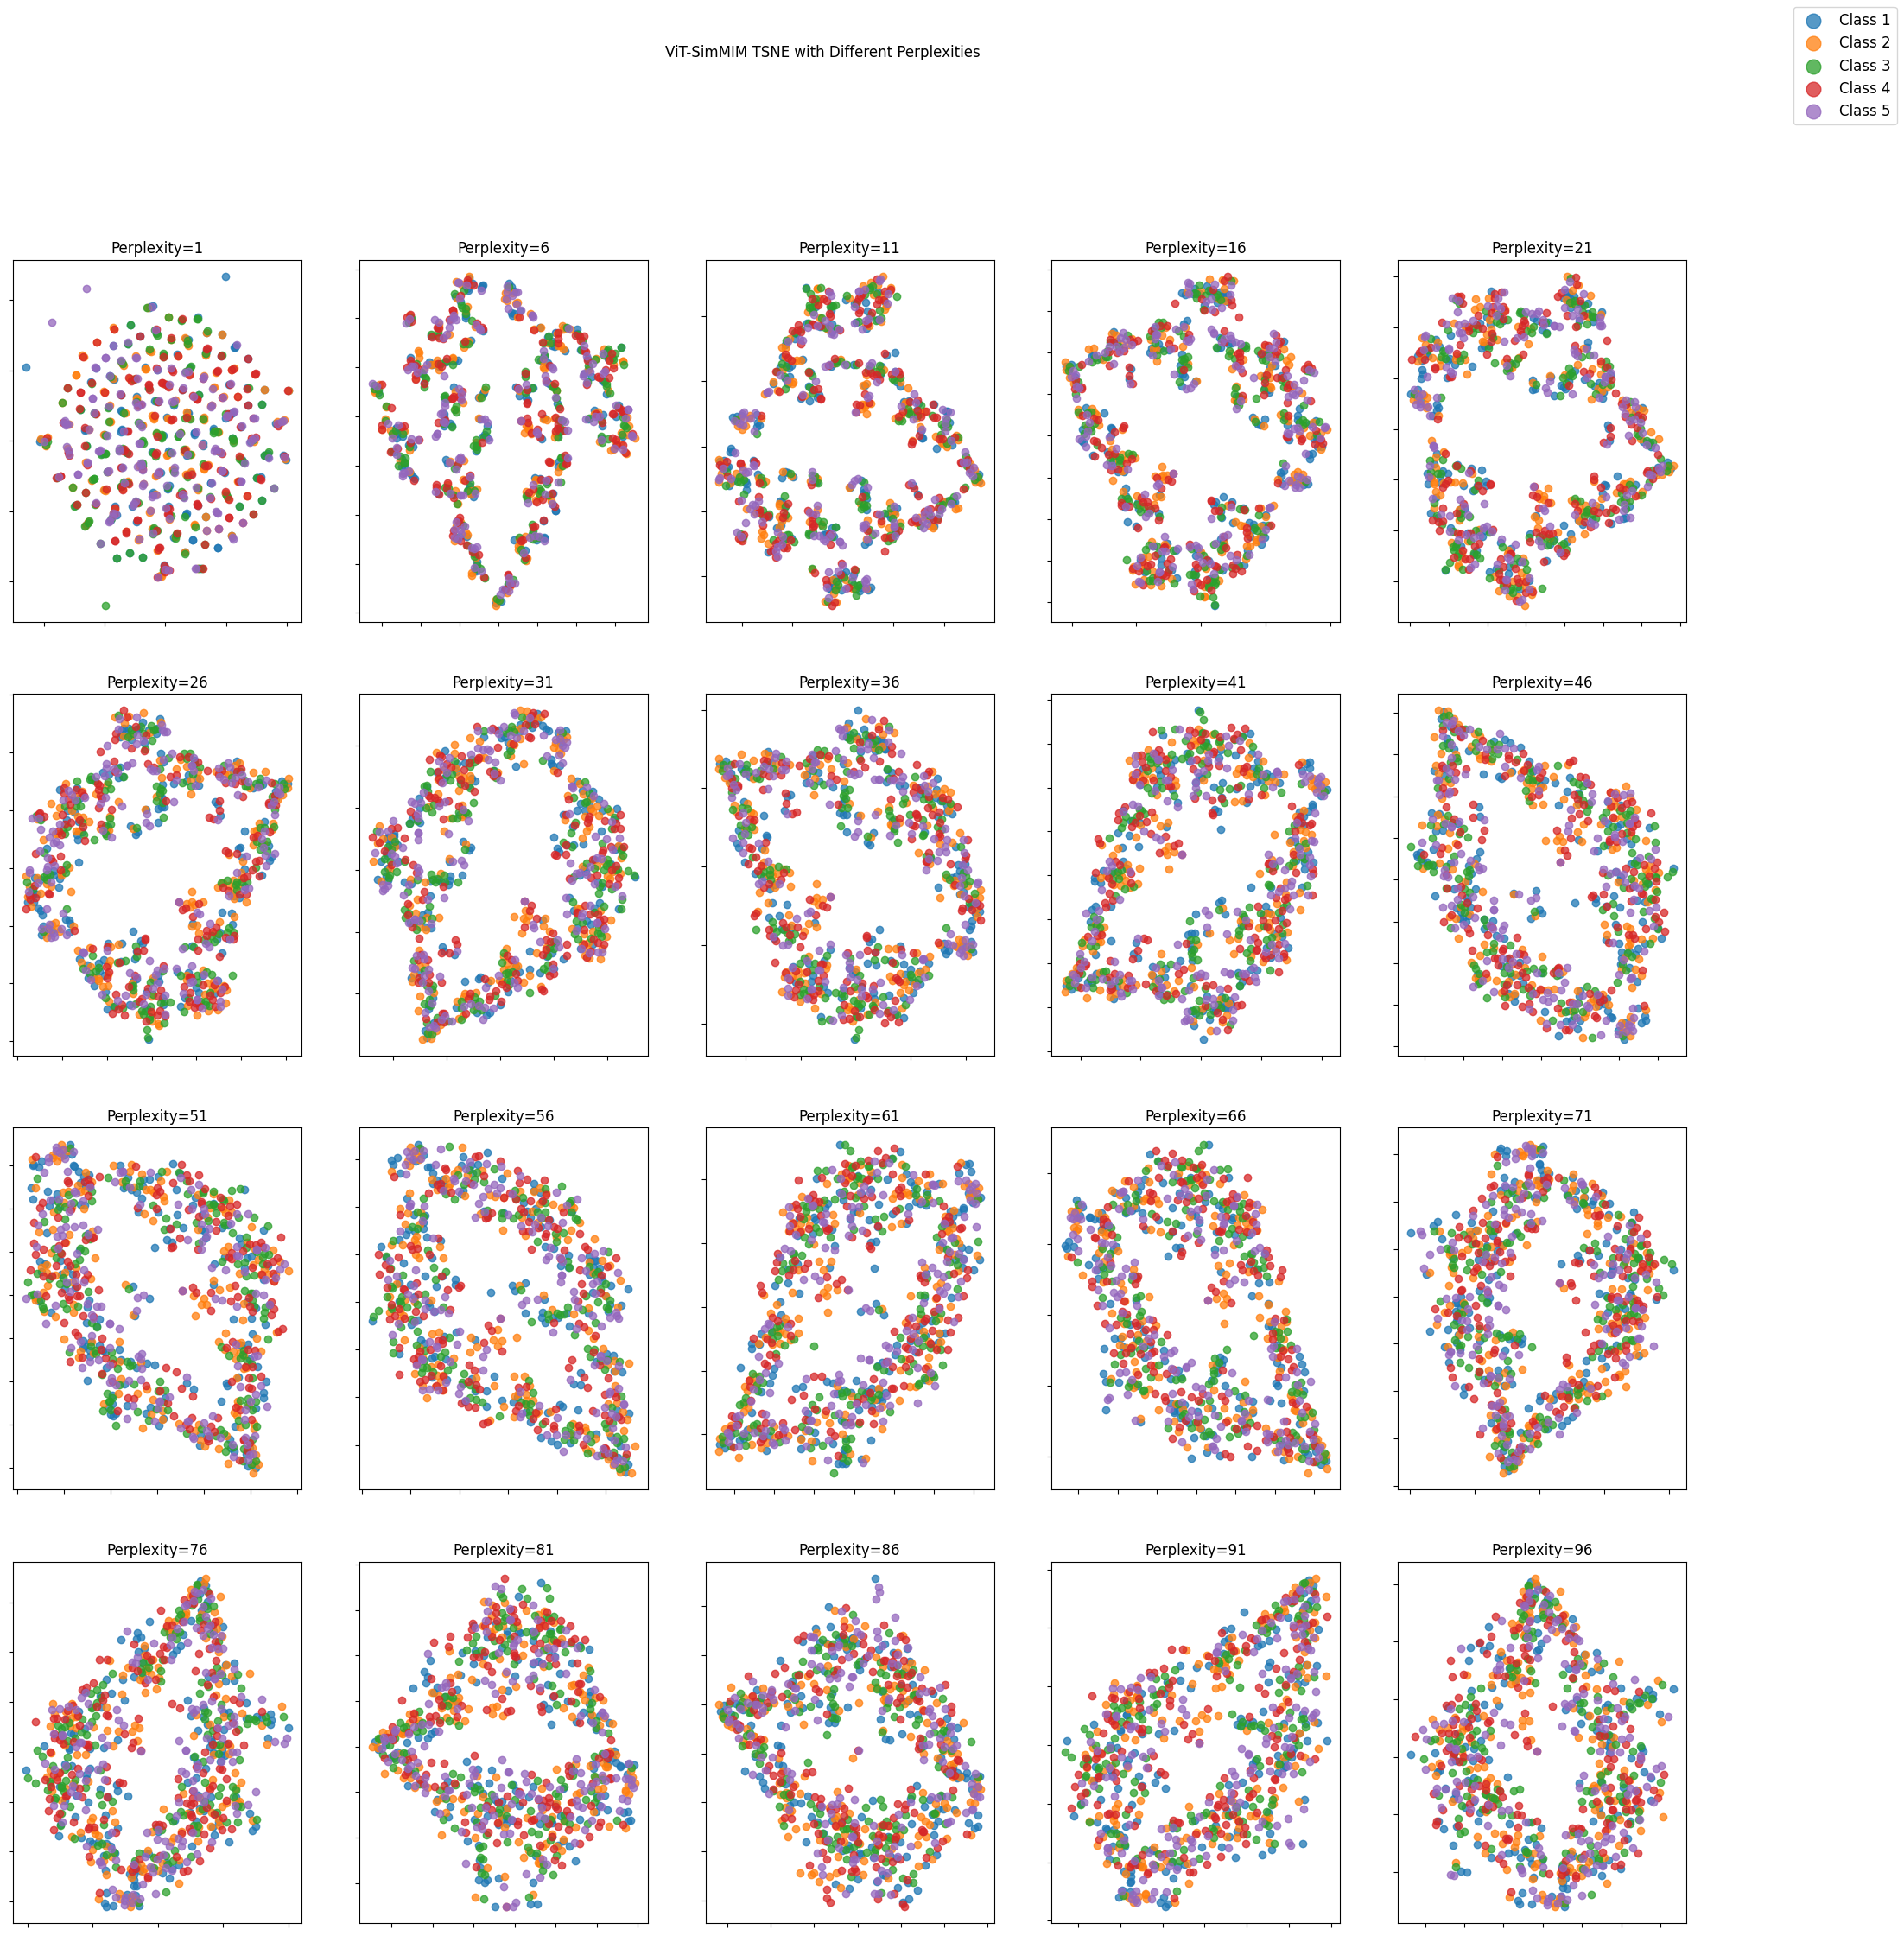

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import NullFormatter
from sklearn.manifold import TSNE

# Assuming `test_embeddings` and `test_targets` are defined somewhere in your code
# Here is a mock definition for illustration:
# test_embeddings = np.random.rand(150, 50)
# test_targets = np.random.randint(1, 6, 150)

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

# Configuration
n_components = 2
perplexities = list(range(1, 101, 5))  # Perplexities from 1 to 100 with a step of 10
num_categories = 5  # Assuming your targets range from 1 to 5
(fig, subplots) = plt.subplots(4, 5, figsize=(25, 25))  # 5 rows, 5 columns of subplots

# Flatten subplots array for easier iteration
subplots = subplots.flatten()

# Create TSNE projections with different perplexities
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=perplexity, metric="cosine", early_exaggeration=12, n_iter=1000)
    tsne_proj = tsne.fit_transform(embeddings)
    
    cmap = cm.get_cmap('tab20')
    for lab in range(1, num_categories + 1):
        indices = targets == lab
        if i == 0:
            ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], label=f'Class {lab}', alpha=0.75, cmap=cmap)
        else:
            ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], alpha=0.75, cmap=cmap)    
    ax.set_title(f"Perplexity={perplexity}")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    
fig.legend(fontsize='large', markerscale=2)
plt.suptitle(f"ViT-SimMIM TSNE with Different Perplexities")
plt.savefig('/kaggle/working/ViT-SimMIM-different-perplexities.png')
plt.show()
